# From Scratch: Building a Neural Network with NumPy

This notebook contains an end-to-end implementation of a simple feedforward neural network using **only NumPy** — no deep learning frameworks involved. It aims to demystify the inner workings of neural networks by walking through each component step-by-step, with a strong focus on **clarity, interactivity, and visualization**.

## Key Features

- **Manual forward and backward passes** (no autograd)

> *This project is inspired by university coursework, but developed independently from scratch to reinforce my understanding and extend the ideas further.*

In case of any questions or comments, please contact me at ea.arseneva@gmail.com


## Plans:
### Data and Training
- (DONE) ~~Early stopping mechanism to prevent overfitting~~    (4)
- Implement k-fold cross-validation                  (6)
- (DONE) ~~Learning rate scheduling~~                           (5)
- Training on other toy datasets (e.g., digit recognition or synthetic classification)                                      (11)

### Visualization and Interactivity
- (DONE) ~~Decision boundary visualization during training~~    (2)
- (DONE) ~~Loss and accuracy plots after training~~  (1)
- (DONE) ~~Visual explanation of gradients and weight updates~~ (3)
- Interactive sliders for hyperparameters (learning rate, network architecture)                                        (12)

### Model Improvements
- Batch normalization implementation                 (9)
- Dropout layers for regularization                  (10)
- Different weight initialization strategies         (8) 
- Additional optimizers (Adam, RMSprop)              (7)

### Future Improvements (OPTIONAL)
- Training history tracking and logging
- Model checkpointing and saving
- Comprehensive testing suite
- Performance optimization

In [14]:
import numpy as np
from abc import ABC, abstractmethod
import matplotlib.pyplot as plt
import time
import copy 

# Set random seed for reproducibility
np.random.seed(42)

In [15]:
# utility functions

def softmax(x: np.ndarray) -> np.ndarray:
    '''
    Compute softmax values for each sets of scores in x.
    x: 2D array of shape (n_samples, n_classes)
    return: 2D array of shape (n_samples, n_classes) with softmax probabilities
    
    The softmax function is defined as:
    softmax(x_i) = exp(x_i) / sum(exp(x_j))
    where x_i is the i-th element of the input vector x and the sum is over all elements in x.
    '''
    # Subtract max for numerical stability
    exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))
    return exp_x / np.sum(exp_x, axis=1, keepdims=True)

def generate_spiral_data(n_points_per_class: int, n_classes: int):
    '''
    Generate spiral data for classification.
    n_points_per_class: number of points per class
    n_classes: number of classes
    return: tuple (X, y_one_hot)
    X: 2D array of shape (n_samples, 2) with the data points
    y_one_hot: 2D array of shape (n_samples, n_classes) with one-hot encoded labels
    '''
    x = []
    y = []
    for j in range(n_classes):
        ix = range(n_points_per_class * j, n_points_per_class * (j + 1))
        r = np.linspace(0.0, 1, n_points_per_class)
        t = np.linspace(j * 4, (j + 1) * 4, n_points_per_class) + np.random.randn(n_points_per_class) * 0.2
        x1 = r * np.sin(t)
        x2 = r * np.cos(t)
        x.append(np.c_[x1, x2])
        y.append(np.full(n_points_per_class, j))
    x = np.vstack(x)
    y = np.hstack(y)
    y_one_hot = np.eye(n_classes)[y]
    return x, y_one_hot



In [16]:
#Define abstract classes for Layer, Loss, Optimizer

class Layer(ABC):
    '''
    Abstract base class for all layers in the neural network.
    Each layer should implement the forward and backward methods, 
    the instances store their input and output dimensions.
    '''
    
    def __init__(self, input_dim=None, output_dim=None):
        self._input_dim = input_dim
        self._output_dim = output_dim
        self.input = None

    @property
    def input_dim(self):
        return self._input_dim

    @property
    def output_dim(self):
        return self._output_dim
    
    
    @abstractmethod
    def forward(self, x: np.ndarray) -> np.ndarray:
        """
        Forward pass through the layer.
        Args:
            x (np.ndarray): Input data. The shape should be (batch_size, input_dim).
        Returns:
            np.ndarray: Output data. The shape should be (batch_size, output_dim).
        """
        pass

    @abstractmethod
    def backward(self, grad: np.ndarray) -> np.ndarray:
        """
        Backward pass through the layer.
        Args:
            grad (np.ndarray): Gradient of the loss with respect to the output. 
            The shape should be (batch_size, output_dim).
        Returns:
            np.ndarray: Gradient of the loss with respect to the input.
            The shape should be (batch_size, input_dim).
        """
        pass

class Loss(ABC):
    '''
    Abstract base class for all loss functions.
    Each loss function should implement the forward and backward methods.
    '''
    
    @abstractmethod
    def forward(self, y_true: np.ndarray, y_pred: np.ndarray) -> tuple:
        """
        Forward pass through the loss function.
        Args:
            y_true (np.ndarray): True labels. The shape should be (batch_size,).
            y_pred (np.ndarray): Predicted labels. The shape should be (batch_size,).
        Returns:
            tuple: A tuple containing the loss value and the predicted probabilities.
            The first element is a scalar (loss value), and the second element is an array of shape (batch_size,).
        """
        pass

    @abstractmethod
    def backward(self, y_true: np.ndarray, y_pred: np.ndarray, probs: np.ndarray) -> np.ndarray:
        """
        Backward pass through the loss function.
        Args:
            y_true (np.ndarray): True labels. The shape should be (batch_size,).
            y_pred (np.ndarray): Predicted labels. The shape should be (batch_size,).
            probs (np.ndarray): Predicted probabilities. The shape should be (batch_size,).
        Returns:
            np.ndarray: Gradient of the loss with respect to the predictions. The shape should be (batch_size,).
        """
        pass
    
class Optimizer(ABC):
    @abstractmethod
    def step(self, params: np.ndarray, grads: np.ndarray) -> None:
        """
        Update the parameters based on the gradients.
        Args:
            params (np.ndarray): Parameters to be updated. The shape should be (num_params,).
            grads (np.ndarray): Gradients of the loss with respect to the parameters. The shape should be (num_params,).
        Returns:
            None
        """
        pass
    
    def update_learning_rate(self, new_lr: float) -> None:
        """
        Update the learning rate of the optimizer.
        Args:
            new_lr (float): New learning rate.
        Returns:
            None
        """
        self.learning_rate = new_lr
    

In [17]:
# Define concrete implementation of Layer: Linear, ReLU, and Sequential

class ReLU(Layer):
    '''
    ReLU layer.
    Applies the ReLU activation function element-wise to the input.
    The ReLU function is defined as f(x) = max(0, x).
    '''
    def __init__(self):
        super().__init__()
        
    def forward(self, x: np.ndarray) -> np.ndarray:
        self.input = x
        return np.maximum(0, x)

    def backward(self, grad: np.ndarray) -> np.ndarray:
        assert grad.shape == self.input.shape, f"Gradient shape {grad.shape} does not match input shape {self.input.shape}"
        # Gradient of ReLU is 1 for positive inputs, 0 for negative inputs
        return grad * (self.input > 0)
    
    
class Linear(Layer):
    '''
    Linear layer.
    Applies a linear transformation to the input data.
    The transformation is defined as y = xW + b, where W is the weight matrix and b is the bias vector.
    '''
    def __init__(self, input_dim: int, output_dim: int):
        assert input_dim > 0 and output_dim > 0, "Input and output dimensions of a Linear layer must be positive integers."
        super().__init__(input_dim, output_dim)
        # Initialize weights and bias
        #self.weights = np.random.randn(input_dim, output_dim) * 0.01
        # Xavier/Glorot initialization instead of fixed scale
        self.weights = np.random.randn(input_dim, output_dim) * np.sqrt(2.0 / input_dim)
        self.bias = np.zeros((1, output_dim))
        self.grad_weights = None
        self.grad_bias = None   

    def forward(self, x: np.ndarray) -> np.ndarray:
        assert x.shape[1] == self.weights.shape[0], f"Input shape {x.shape} does not match expected shape (batch_size, {self.weights.shape[0]})"
        assert self.weights.shape[1] == self.bias.shape[1], f"Weights shape {self.weights.shape} does not match bias shape {self.bias.shape}"
        self.input = x
        return x @ self.weights + self.bias

    def backward(self, grad: np.ndarray) -> np.ndarray:
        assert grad.shape[1] == self.bias.shape[1], f"Gradient shape {grad.shape} does not match bias shape {self.bias.shape}"
        assert grad.shape[0] == self.input.shape[0], f"Gradient shape {grad.shape} does not match input shape {self.input.shape}"
        # Gradient of the loss with respect to the input
        grad_input = grad @ self.weights.T
        # Gradient of the loss with respect to the weights and bias
        self.grad_weights = self.input.T @ grad
        self.grad_bias = np.sum(grad, axis=0, keepdims=True)
              
        # Monitor gradient statistics
        grad_stats = {
            'input_grad_max': np.abs(grad_input).max(),
            'weight_grad_max': np.abs(self.grad_weights).max(),
            'bias_grad_max': np.abs(self.grad_bias).max()
        }
    
        if any(np.isnan(v) or np.isinf(v) for v in grad_stats.values()):
            raise ValueError(f"Invalid gradients detected: {grad_stats}")
        
        return grad_input 
    
class Sequential(Layer):
    '''
    Sequential model.
    A container for stacking layers in a linear fashion.
    The input to the first layer is the input to the model, and the output of the last layer is the output of the model.
    '''
    def __init__(self, layers: list):
        self.layers = layers
        super().__init__(layers[0].input_dim, layers[-1].output_dim)
        self.__check_consistency__()

    def __check_consistency__(self):
        assert len(self.layers) > 1, "Sequential model must have at least one layer."
        assert self.layers[0].input_dim is not None, "First layer input dimension must be specified."
        assert self.layers[-1].output_dim is not None, "Last layer output dimension must be specified."
        assert self.layers[0].input_dim == self.input_dim, f"First layer input dimension {self.layers[0].input_dim} does not match expected input dimension {self.input_dim}"
        assert self.layers[-1].output_dim == self.output_dim, f"Last layer output dimension {self.layers[-1].output_dim} does not match expected output dimension {self.output_dim}"
        current_dim = self.input_dim
        mismatch_list = []
        for layer in self.layers:
            if layer.input_dim != None:
                if layer.input_dim != current_dim: 
                    mismatch_list.append(f"Layer {layer.__class__.__name__} input dimension {layer.input_dim} does not match expected input dimension {current_dim}")
                current_dim = layer.output_dim
        assert len(mismatch_list) == 0, f"Layer dimension mismatch: {'\n'.join(mismatch_list)}"
                        
    def forward(self, x: np.ndarray) -> np.ndarray:
        assert x.shape[1] == self.layers[0].input_dim, f"Input shape {x.shape} does not match expected shape (batch_size, {self.layers[0].input_dim})"
        for layer in self.layers:
            x = layer.forward(x)
        return x

    def backward(self, grad: np.ndarray) -> np.ndarray:
        for layer in reversed(self.layers):
            grad = layer.backward(grad)
        return grad
    
    def summary(self) -> None:
        """Print a summary of the model architecture."""
        print("Model Summary:")
        print("-" * 50)
        total_params = 0
        for i, layer in enumerate(self.layers):
            if isinstance(layer, Linear):
                params = np.prod(layer.weights.shape) + np.prod(layer.bias.shape)
                total_params += params
                print(f"Layer {i}: {layer.__class__.__name__}, "
                      f"Input: {layer.input_dim}, Output: {layer.output_dim}, "
                      f"Parameters: {params}")
            else:
                print(f"Layer {i}: {layer.__class__.__name__}")
        print("-" * 50)
        print(f"Total parameters: {total_params}")
        print("-" * 50)
        print("-" * 50)

In [18]:
# Define concrete implementation of Loss: MeanSquaredError and CrossEntropy

class MeanSquaredError(Loss):
    '''
    Mean Squared Error (MSE) loss function.
    It measures the average squared difference between the predicted and true values.
    The MSE is defined as:
    MSE = (1/n) * sum((y_true - y_pred)^2)
    where n is the number of samples, y_true is the true labels, and y_pred is the predicted labels.
    '''
    def forward(self, y_true: np.ndarray, y_pred: np.ndarray) -> tuple:
        assert y_true.shape == y_pred.shape, f"True labels shape {y_true.shape} does not match predicted labels shape {y_pred.shape}"
        return np.mean(np.square(y_true - y_pred)), y_pred

    def backward(self, y_true: np.ndarray, y_pred: np.ndarray) -> np.ndarray:
        assert y_true.shape == y_pred.shape, f"True labels shape {y_true.shape} does not match predicted labels shape {y_pred.shape}"
        return 2 * (y_pred - y_true) / y_true.size
    
    
class CrossEntropySoftMax(Loss):
    '''
    Cross-entropy loss function with softmax activation.
    It is used for multi-class classification problems.
    The cross-entropy loss is defined as:
    CE = -sum(y_true * log(probs))
    where y_true is the true labels (one-hot encoded) and probs is the predicted probabilities.
    '''
    
    def forward(self, y_true: np.ndarray, y_pred_logits: np.ndarray) -> tuple:
        '''
        Forward pass through the cross-entropy loss function.
        Args:
            y_true (np.ndarray): True labels (one-hot encoded). The shape should be (batch_size, n_classes).
            y_pred_logits (np.ndarray): Predicted logits. The shape should be (batch_size, n_classes).
        Returns:
            tuple: A tuple containing the loss value and the predicted probabilities.
            The first element is a scalar (loss value), and the second element is an array of shape (batch_size, n_classes).
        '''
        assert y_true.shape == y_pred_logits.shape, f"True labels shape {y_true.shape} does not match predicted logits shape {y_pred_logits.shape}"
        #apply softmax to the predictions
        probs = softmax(y_pred_logits)
        loss = -np.sum(y_true * np.log(probs + 1e-15)) / y_true.shape[0]
        return loss, probs

    def backward(self, y_true: np.ndarray, probs: np.ndarray) -> np.ndarray:
        '''
        Backward pass through the cross-entropy loss function.
        Args:
            y_true (np.ndarray): True labels (one-hot encoded). The shape should be (batch_size, n_classes).
            probs (np.ndarray): Predicted probabilities. The shape should be (batch_size, n_classes).
        Returns:
            np.ndarray: Gradient of the loss with respect to the predictions. The shape should be (batch_size, n_classes).
        '''
        
        assert y_true.shape == probs.shape, f"True labels shape {y_true.shape} does not match prediction shape {probs.shape}"
        return (probs - y_true)/y_true.shape[0]

In [19]:
# Define concrete implementation of Optimizer: SGD

class SGD(Optimizer):
    '''
    Stochastic Gradient Descent (SGD) optimizer.
    It updates the parameters using the gradients and a learning rate.
    The update rule is defined as:
    params = params - learning_rate * grads
    where params are the parameters to be updated, learning_rate is the learning rate, and grads are the gradients.
    '''
    
    def __init__(self, learning_rate: float = 0.01):
        assert learning_rate > 0, "Learning rate must be a positive number."
        self.learning_rate = learning_rate

    def step(self, params: np.ndarray, grads: np.ndarray) -> None:
        assert params.shape == grads.shape, f"Parameters shape {params.shape} does not match gradients shape {grads.shape}"
        params -= self.learning_rate * grads

In [20]:
# Put everything together in a very simplistic training loop 
# Note: better training infrastructure can be found in this notebook further on
perform_simple_training = False


def simple_train(model: Sequential, loss_fn: Loss, optimizer: Optimizer, x_train: np.ndarray, y_train: np.ndarray, batch_size: int = 32, epochs: int = 1000):
    '''
    Train the model using the specified loss function and optimizer. No cross-validation is performed.
    The training loop consists of the following steps:
    1. Forward pass: Compute the predicted labels using the model.
    2. Compute the loss using the loss function.
    3. Backward pass: Compute the gradients of the loss with respect to the model parameters.
    4. Update the model parameters using the optimizer.
    5. Repeat steps 1-4 for the specified number of epochs.
    6. Print the loss every 100 epochs.
    7. Return the trained model.
    Args:
        model (Sequential): The model to be trained.
        loss_fn (Loss): The loss function to be used.
        optimizer (Optimizer): The optimizer to be used.
        x_train (np.ndarray): Training data. The shape should be (n_samples, n_features).
        y_train (np.ndarray): Training labels. The shape should be (n_samples, n_classes).
        batch_size (int): Batch size for training. Default is 32.
        epochs (int): Number of epochs for training. Default is 1000.
    Returns:
        None
    '''
    for epoch in range(epochs):
        epoch_loss = 0
        # go in batches
        for i in range(0, x_train.shape[0], batch_size):
            x_batch = x_train[i:i + batch_size]
            y_batch = y_train[i:i + batch_size]
            
            # Forward pass
            y_pred = model.forward(x_batch)
            
            # Compute loss
            batch_loss, probs = loss_fn.forward(y_batch, y_pred)
            epoch_loss += batch_loss
            
            # Backward pass
            grad = loss_fn.backward(y_batch, probs)
            model.backward(grad)
            
            # Update parameters
            for layer in model.layers:
                if isinstance(layer, Linear):
                    optimizer.step(layer.weights, layer.grad_weights)
                    optimizer.step(layer.bias, layer.grad_bias)
        # Average loss for the epoch
        epoch_loss /= (x_train.shape[0] // batch_size)

        # Print loss every 100 epochs
        if epoch % 100 == 0:
            print(f"Epoch {epoch}, Loss: {epoch_loss}")
            

#Define a simple model and apply it to spiral dataset
model = Sequential([
    Linear(2, 32),
    ReLU(),
    Linear(32, 5),
])
loss_fn = CrossEntropySoftMax()
optimizer = SGD(learning_rate=0.01)

if perform_simple_training: 
    # Train the model
    x_train, y_train = generate_spiral_data(1000, 5)
    x_test, y_test = generate_spiral_data(200, 5)
    simple_train(model, loss_fn, optimizer, x_train, y_train, epochs=1000, batch_size=10)
    # Test the model
    y_pred = model.forward(x_test)
    predicted_labels = np.argmax(y_pred, axis=1)
    true_labels = np.argmax(y_test, axis=1)
    accuracy = np.mean(predicted_labels == true_labels)
    print(f"Test Accuracy: {accuracy * 100:.2f}%")

In [21]:
# Dataset and DataLoader classes to wrap the data and operate on batches
class Dataset:
    '''
    Dataset class to hold the data and labels.
    It provides methods to access the data and labels by index.
    '''
    def __init__(self, x: np.ndarray, y: np.ndarray):
        self.x = x
        self.y = y

    def __len__(self):
        return len(self.x)

    def __getitem__(self, index):
        assert isinstance(index, (int, np.ndarray)), "Index must be an integer or a numpy array."
        return self.x[index], self.y[index]
    
class DataLoader:
    '''
    DataLoader class to load the data in batches.
    It provides methods to iterate over the data in batches.
    '''
    def __init__(self, dataset: Dataset, indices = None, batch_size: int = 32, shuffle: bool = False) -> None:
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indices = indices if indices is not None else np.arange(len(dataset))
        self.current_index = 0

    def __iter__(self):
        self.current_index = 0
        if self.shuffle:
            np.random.shuffle(self.indices)
        return self

    def __next__(self):
        if self.current_index >= len(self.indices):
            raise StopIteration
        start_index = self.current_index
        end_index = min(start_index + self.batch_size, len(self.indices))
        batch_indices = self.indices[start_index:end_index]
        x_batch, y_batch = self.dataset[batch_indices]
        self.current_index += self.batch_size
        return x_batch, y_batch
    
    def __len__(self):
        return int(np.ceil(len(self.indices) / self.batch_size))
    
    @staticmethod
    def holdout_split(dataset: Dataset, test_size: float = 0.2):
        """
        Splits the dataset into training and testing sets.
        Args:
            dataset (Dataset): The dataset to split.
            test_size (float): The proportion of the dataset to include in the test split.
        Returns:
            DataLoader: Loader for the training portion of the dataset.
            DataLoader: Loader for the testing portion of the dataset.
        """
        assert 0 < test_size < 1, "test_size must be between 0 and 1."
        indices = np.arange(len(dataset))
        np.random.shuffle(indices)
        split_index = int(len(dataset) * (1 - test_size))
        train_indices = indices[:split_index]
        test_indices = indices[split_index:]
        return DataLoader(dataset, train_indices), DataLoader(dataset, test_indices)
    



In [22]:
# Learning rate scheduler

class LRScheduler(ABC):
    '''
    Abstract base class for learning rate schedulers.
    Each scheduler should implement the get_lr method to compute the current learning rate.
    '''
    def __init__(self, initial_lr: float):
        assert initial_lr > 0, "Initial learning rate must be positive"
        self.initial_lr = initial_lr
        self.current_step = 0
        
    @abstractmethod
    def get_lr(self) -> float:
        """Calculate the learning rate for the current step"""
        pass
    
    def step(self) -> None:
        """Increment the step counter"""
        self.current_step += 1

class StepLRScheduler(LRScheduler):
    """Decays learning rate by gamma every step_size epochs"""
    def __init__(self, initial_lr: float, step_size: int, gamma: float = 0.1):
        super().__init__(initial_lr)
        self.step_size = step_size
        self.gamma = gamma
        
    def get_lr(self) -> float:
        return self.initial_lr * (self.gamma ** (self.current_step // self.step_size))

class ExponentialLRScheduler(LRScheduler):
    """Exponentially decays learning rate by gamma every epoch"""
    def __init__(self, initial_lr: float, gamma: float = 0.95):
        super().__init__(initial_lr)
        self.gamma = gamma
        
    def get_lr(self) -> float:
        return self.initial_lr * (self.gamma ** self.current_step)
    
class WarmupLRScheduler(LRScheduler):
    def __init__(self, initial_lr: float, warmup_epochs: int = 50):
        super().__init__(initial_lr)
        self.warmup_epochs = warmup_epochs
        
    def get_lr(self) -> float:
        if self.current_step < self.warmup_epochs:
            return self.initial_lr * (self.current_step / self.warmup_epochs)
        return self.initial_lr * 0.5 * (1 + np.cos(np.pi * (self.current_step - self.warmup_epochs) / (1000 - self.warmup_epochs)))

In [23]:

# class TrainingVisualizer that stores the training history and plots the loss and accuracy

class TrainingVisualizer:
    '''
    TrainingVisualizer class to store the training history and plot the loss and accuracy.
    It provides methods to update the training history and plot the loss and accuracy.
    '''
    def __init__(self):
        self.history = {
            'loss': [],
            'val_loss': [],
            'train_acc': [],
            'val_acc': []
        }
        self.grid = None
        self.grid_coords = None
        
    def update(self, loss: float, val_loss: float, train_acc: float, val_acc: float):
        '''
        Update the training history with the current loss and accuracy.
        Args:   
            loss (float): Current loss.
            val_loss (float): Current validation loss.
            train_acc (float): Current training accuracy.
            val_acc (float): Current validation accuracy.
        Returns:
            None
        '''
        self.history['loss'].append(loss)
        self.history['val_loss'].append(val_loss)
        self.history['train_acc'].append(train_acc)
        self.history['val_acc'].append(val_acc)

    def plot_metrics_history(self):
        '''
        Plot the training history.
        It plots the loss and accuracy for both training and validation sets.
        Returns:
            None
        '''
        assert len(self.history['loss']) > 0, "No training history to plot."
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
        
        epochs = range(len(self.history['loss']))
        # Plot loss
        ax1.plot(epochs, self.history['loss'], 'b-', label='Train Loss')
        ax1.plot(epochs, self.history['val_loss'], 'r-', label='Val Loss')
        ax1.set_title('Loss')
        ax1.set_xlabel('Epochs')
        ax1.set_ylabel('Loss')
        ax1.legend()
        
        # Plot accuracy
        ax2.plot(epochs, self.history['train_acc'], 'b-', label='Train Accuracy')
        ax2.plot(epochs, self.history['val_acc'], 'r-', label='Val Accuracy')
        ax2.set_title('Accuracy')
        ax2.set_xlabel('Epochs')
        ax2.set_ylabel('Accuracy (%)')
        ax2.legend()
        
        plt.tight_layout()
        plt.show()     
    
    def plot_decision_boundary(self, model, x_train, y_train, ax=None):
        if ax is None:
            fig, ax = plt.subplots(figsize=(8, 6))
        
        # Create grid first time only
        if self.grid is None:
            # Extend bounds a bit further for better visualization
            x_min, x_max = x_train[:, 0].min() - 1.0, x_train[:, 0].max() + 1.0
            y_min, y_max = x_train[:, 1].min() - 1.0, x_train[:, 1].max() + 1.0
        
            # Increase grid resolution for smoother boundaries
            xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200),
                            np.linspace(y_min, y_max, 200))
            self.grid = np.c_[xx.ravel(), yy.ravel()]
            self.grid_coords = (xx, yy)
    
        # Get predictions for grid points
        grid_predictions = model.forward(self.grid)
        grid_predictions = np.argmax(grid_predictions, axis=1)
    
        # Plot decision boundary with better aesthetics
        ax.contourf(self.grid_coords[0], self.grid_coords[1], 
                 grid_predictions.reshape(self.grid_coords[0].shape),
                 alpha=0.15, cmap='viridis', levels=np.arange(4)-0.5)
    
        # Add contour lines to highlight boundaries
        ax.contour(self.grid_coords[0], self.grid_coords[1],
                grid_predictions.reshape(self.grid_coords[0].shape),
                colors='black', alpha=0.3, linewidths=0.5)
    
        # Plot training points with better visibility
        scatter = ax.scatter(x_train[:, 0], x_train[:, 1], 
                         c=np.argmax(y_train, axis=1), 
                         cmap='viridis',
                         edgecolors='white',
                         s=20,
                         alpha=0.6,  # Some transparency
                         linewidth=0.5)
    
        if hasattr(ax, 'figure'):
            ax.figure.colorbar(scatter, ax=ax, label='Class')
        
        ax.set_xlabel('X', fontsize=12)
        ax.set_ylabel('Y', fontsize=12)
        ax.set_title('Decision Boundary', fontsize=14, pad=10)
    
        # Make plot more aesthetic
        ax.grid(True, alpha=0.2)
        plt.tight_layout()
        if ax is None:
            plt.show()
        
    def weights_gradients_heatmap(self, model: Sequential, optimizer: Optimizer, ax=None) -> None:
        '''
        Plot the weights and their updates during training.
        Args:
            model: Sequential model to visualize
            optimizer: Optimizer instance to calculate updates
            ax: Matplotlib axes to plot on, if None a new figure is created
        Returns:
            None
        '''
        
        # Get all Linear layers
        linear_layers = [(i, layer) for i, layer in enumerate(model.layers) 
                          if isinstance(layer, Linear)]
    
        if not linear_layers:
            print("No linear layers to visualize.")
            return
        
        num_layers = len(linear_layers)
    
        # Create figure with subplots for each layer
        if ax is None:
            fig, axes = plt.subplots(num_layers, 2, figsize=(12, 4 * num_layers))
            if num_layers == 1:  # Handle the case of single layer
                axes = axes.reshape(1, 2)
        else:
            axes = ax if num_layers > 1 else ax.reshape(1, 2)
        
         # Plot each hidden layer
        for i, (layer_num, layer) in enumerate(linear_layers):
            # 1. Plot normalized weights
            weights_norm = layer.weights / np.abs(layer.weights).max()
            im1 = axes[i, 0].imshow(weights_norm, cmap='RdBu', vmin=-1, vmax=1)
            axes[i, 0].set_title(f'Layer {layer_num} Weights\nMax abs value: {np.abs(layer.weights).max():.4f}')
            plt.colorbar(im1, ax=axes[i, 0])

            # 2. Plot gradient-based updates if available
            if layer.grad_weights is not None:
                update = optimizer.learning_rate * layer.grad_weights
                update_norm = update / np.abs(update).max() if np.abs(update).max() > 0 else update
                im2 = axes[i, 1].imshow(update_norm, cmap='RdBu', vmin=-1, vmax=1)
                axes[i, 1].set_title(f'Layer {layer_num} Updates (lr={optimizer.learning_rate})\nMax abs value: {np.abs(update).max():.4f}')
                plt.colorbar(im2, ax=axes[i, 1])

            # Add labels
            axes[i, 0].set_xlabel('Output features')
            axes[i, 0].set_ylabel('Input features')
            axes[i, 1].set_xlabel('Output features')
            axes[i, 1].set_ylabel('Input features')

        plt.suptitle('Weight Values and Their Updates', y=1.02, fontsize=14)
    
        if ax is None:
            plt.tight_layout()
            plt.show()
    
        
    def plot_loss_landscape(self, model: Sequential, loader: DataLoader, loss_fn: Loss, ax=None):
        """Visualize loss landscape around current weights"""
        if ax is None:
            fig, ax = plt.subplots(figsize=(8, 6))
        
        losses = []
        epsilons = np.linspace(-1, 1, 20)
    
        # Store original weights
        original_weights = [(layer.weights.copy(), layer.bias.copy()) 
                       for layer in model.layers if isinstance(layer, Linear)]
    
        for eps in epsilons:
            # Perturb weights
            for layer, (w, b) in zip([l for l in model.layers if isinstance(l, Linear)], 
                                original_weights):
                layer.weights = w + eps * np.random.randn(*w.shape) * 0.1
                layer.bias = b + eps * np.random.randn(*b.shape) * 0.1
        
            # Compute loss
            total_loss = 0
            n_samples = 0
            for x_batch, y_batch in loader:
                y_pred = model.forward(x_batch)
                loss, _ = loss_fn.forward(y_batch, y_pred)
                total_loss += loss * len(x_batch)
                n_samples += len(x_batch)
            losses.append(total_loss / n_samples)
    
            # Restore original weights
            for layer, (w, b) in zip([l for l in model.layers if isinstance(l, Linear)], 
                            original_weights):
                layer.weights = w
                layer.bias = b
    
        ax.plot(epsilons, losses)
        ax.set_xlabel('Perturbation magnitude')
        ax.set_ylabel('Loss')
        ax.set_title('Loss Landscape')
        ax.grid(True)
        if ax is None:
            plt.show()
        

class KFoldVisualizer(TrainingVisualizer):
    """Extended visualizer for k-fold cross validation"""
    def __init__(self, k_folds: int):
        super().__init__()
        self.k_folds = k_folds
        self.fold_histories = []
        
    def add_fold_history(self, fold_history: dict):
        """Store history for one fold"""
        self.fold_histories.append(fold_history)
    
    def plot_k_fold_results(self):
        """Plot aggregated results across folds"""
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
        
        # Plot individual fold histories
        for i, hist in enumerate(self.fold_histories):
            ax1.plot(hist['val_loss'], alpha=0.3, label=f'Fold {i+1}')
            ax2.plot(hist['val_acc'], alpha=0.3)
        
        # Plot mean ± std
        val_losses = np.array([h['val_loss'] for h in self.fold_histories])
        val_accs = np.array([h['val_acc'] for h in self.fold_histories])
        
        epochs = range(len(val_losses[0]))
        mean_loss = np.mean(val_losses, axis=0)
        std_loss = np.std(val_losses, axis=0)
        mean_acc = np.mean(val_accs, axis=0)
        std_acc = np.std(val_accs, axis=0)
        
        ax1.plot(epochs, mean_loss, 'r-', label='Mean Loss', linewidth=2)
        ax1.fill_between(epochs, mean_loss-std_loss, mean_loss+std_loss, alpha=0.2)
        ax1.set_title(f'Validation Loss Across {self.k_folds} Folds')
        ax1.set_xlabel('Epochs')
        ax1.set_ylabel('Loss')
        ax1.legend()
        
        ax2.plot(epochs, mean_acc, 'r-', label='Mean Accuracy', linewidth=2)
        ax2.fill_between(epochs, mean_acc-std_acc, mean_acc+std_acc, alpha=0.2)
        ax2.set_title(f'Validation Accuracy Across {self.k_folds} Folds')
        ax2.set_xlabel('Epochs')
        ax2.set_ylabel('Accuracy (%)')
        ax2.legend()
        
        plt.tight_layout()
        plt.show()

    

In [24]:
# CrossValidator class to perform k-fold cross-validation and other validation strategies
# In progress

class CrossValidator:
    def __init__(self, validation_strategy: str = "k-fold", **kwargs):
        assert validation_strategy in ["k-fold", "leave-one-out", "stratified"],\
            "Validation strategy must be one of: 'k-fold', 'leave-one-out', 'stratified'"
        self.validation_strategy = validation_strategy
        self.kwargs = kwargs  # Store parameters like k, etc.
        self.random_state = np.random.RandomState(42)  # Add separate random state


    def get_folds(self, dataset: Dataset) -> list[tuple[np.ndarray, np.ndarray]]:
        """Returns list of (train_indices, val_indices) for the chosen strategy"""
        if self.validation_strategy == "k-fold":
            k = self.kwargs.get('k', 5)
            indices = np.arange(len(dataset))
            self.random_state.shuffle(indices)
            fold_size = len(dataset) // k
            folds = []
            for i in range(k):
                val_idx = indices[i*fold_size:(i+1)*fold_size]
                train_idx = np.concatenate([indices[:i*fold_size], 
                                          indices[(i+1)*fold_size:]])
                folds.append((train_idx, val_idx))
            return folds

In [25]:
# class Trainer that governs the training process, using the DataLoader, ValidationStrategy, and Optimizer

class Trainer:
    def __init__(self, model: Sequential, loss_fn: Loss, optimizer: Optimizer):
        self.model = model
        self.loss_fn = loss_fn
        self.optimizer = optimizer
        self.visualizer = TrainingVisualizer()

    def train(self, train_loader: DataLoader, val_loader: DataLoader, epochs: int = 1000,  show_plots_logs:bool = True, log_interval:int = 200, patience: int = 20, min_delta: float = 1e-4, lr_scheduler: LRScheduler = None, debug: bool = False, **kwargs) -> dict:
        '''
        Train the model using the specified loss function and optimizer.
        The training loop consists of the following steps:
        1. Split the dataset into training and validation sets.
        2. For each epoch:
            a. Iterate over the training set in batches.
            b. Forward pass: Compute the predicted labels using the model.
            c. Compute the loss using the loss function.
            d. Backward pass: Compute the gradients of the loss with respect to the model parameters.
            e. Update the model parameters using the optimizer.
            f. Print the loss every 100 epochs.
        3. Validate the model using the validation set.
        4. Return the trained model.
        Args:
            train_loader (DataLoader): The DataLoader for the training set.
            val_loader (DataLoader): The DataLoader for the validation set.
            epochs (int): Number of epochs for training. Default is 1000.
            show_plots_logs (bool): Whether to show the plots and output statistics regularly during training. Default is True.
            log_interval (int): Interval for showing plots and statistics. Default is 200.
            patience (int): Number of epochs to wait for improvement before early stopping. Default is 10.
            min_delta (float): Minimum change in the validation loss to qualify as an improvement. Default is 1e-4.
            lr_scheduler (LRScheduler): Learning rate scheduler to adjust the learning rate during training.
            **kwargs: Additional arguments (e.g., batch_size)
        Returns:
            dict: Training history containing loss, validation loss, training accuracy, and validation accuracy.
        '''
        
        if debug:
            stats = {}
            for i, layer in enumerate(self.model.layers):
                if isinstance(layer, Linear):
                    stats[f'layer_{i}'] = {
                        'weight_norm': np.linalg.norm(layer.weights),
                        'grad_norm': np.linalg.norm(layer.grad_weights) if layer.grad_weights is not None else 0
                    }
            weight_stats.append(stats)
        
        def validate_metrics(loss, val_loss, acc):
            """Helper function to validate metrics"""
            if np.isnan(loss) or np.isinf(loss):
                raise ValueError(f"Training loss is {loss}")
            if np.isnan(val_loss) or np.isinf(val_loss):
                raise ValueError(f"Validation loss is {val_loss}")
            if acc < 0 or acc > 100:
                raise ValueError(f"Invalid accuracy value: {acc}")
        
        # If no scheduler provided, create default one
        if lr_scheduler is None:
            lr_scheduler = ExponentialLRScheduler(0.01, gamma=0.99)
            
        epoch_times = [] # List to store training times per epoch for logging
        weight_stats = [] # List to store weight statistics for debugging
        
        # Initialize best validation loss, best model state and patiance counter for early stopping
        best_val_loss = float('inf')
        best_model_state = None
        patience_counter = 0
        
        # Training loop
        for epoch in range(epochs):
            if debug:
                stats = {}
                for i, layer in enumerate(self.model.layers):
                    if isinstance(layer, Linear):
                        stats[f'layer_{i}'] = {
                            'weight_mean': layer.weights.mean(),
                            'weight_std': layer.weights.std(),
                            'weight_max': np.abs(layer.weights).max(),
                            'grad_max': np.abs(layer.grad_weights).max() if layer.grad_weights is not None else 0
                        }
                weight_stats.append(stats)

            start_time = time.time()
            epoch_loss = 0
            n_samples = 0
            
            current_lr = lr_scheduler.get_lr()
            print(f"Epoch {epoch}, LR: {current_lr:.6f}") if epoch % log_interval == 0 else None
            
            self.optimizer.update_learning_rate(current_lr)
            
            # Monitor gradients before updates
            max_grad = 0
            
            for x_batch, y_batch in train_loader:
                
                # Forward pass
                y_pred = self.model.forward(x_batch)
                
                # Compute loss
                loss, probs = self.loss_fn.forward(y_batch, y_pred)
                
                # Check for valid predictions
                if np.any(np.isnan(y_pred)) or np.any(np.isinf(y_pred)):
                    raise ValueError("Invalid predictions detected")
                
                epoch_loss += loss * x_batch.shape[0]
                n_samples += x_batch.shape[0]
                
                # Backward pass with gradient clipping
                grad = self.loss_fn.backward(y_batch, probs)
                max_grad = max(max_grad, np.abs(grad).max())
                grad = np.clip(grad, -1.0, 1.0)
                self.model.backward(grad)
                
                # Update parameters
                for layer in self.model.layers:
                    if isinstance(layer, Linear):
                        if np.any(np.isnan(layer.grad_weights)) or np.any(np.isinf(layer.grad_weights)):
                            raise ValueError("Invalid gradients detected")
                        layer.grad_weights = np.clip(layer.grad_weights, -1.0, 1.0)
                        layer.grad_bias = np.clip(layer.grad_bias, -1.0, 1.0)
                        self.optimizer.step(layer.weights, layer.grad_weights)
                        self.optimizer.step(layer.bias, layer.grad_bias)
            
            #Step the learning rate scheduler
            lr_scheduler.step()
            
            epoch_loss /= n_samples
            
            # compute and validate the metrics for this epoch
            val_loss = self.validate(val_loader)
            train_acc = self.compute_accuracy(train_loader)
            val_acc = self.compute_accuracy(val_loader)
            
            try:
                validate_metrics(epoch_loss, val_loss, train_acc)
            except ValueError as e:
                print(f"Error at epoch {epoch}:")
                print(f"Max gradient magnitude: {max_grad}")
                print(f"Current learning rate: {current_lr}")
                raise e
            
            self.visualizer.update(epoch_loss, val_loss, train_acc, val_acc)
            epoch_times.append(time.time() - start_time)
            # Early stopping check
            if val_loss < best_val_loss*(1 - min_delta):
                best_val_loss = val_loss
                best_model_state = copy.deepcopy([(layer.weights.copy(), layer.bias.copy()) 
                        for layer in self.model.layers 
                        if isinstance(layer, Linear)])
                patience_counter = 0
            else:
                patience_counter += 1

            if patience_counter >= patience:
                print(f"Early stopping triggered after {epoch} epochs")
                # Restore best model
                linear_layers = [l for l in self.model.layers if isinstance(l, Linear)]
                for layer, (weights, bias) in zip(linear_layers, best_model_state):
                    layer.weights = weights.copy()
                    layer.bias = bias.copy()
                    
                # Truncate history at early stopping point
                for key in self.visualizer.history:
                    self.visualizer.history[key] = self.visualizer.history[key][:epoch + 1]
                
                break
            
            # Print loss every log_interval epochs
            if show_plots_logs and epoch % log_interval == 0:
                
                # Create a figure with subplots for all visualizations
                fig = plt.figure(figsize=(15, 12))
                gs = plt.GridSpec(3, 2, height_ratios=[1, 1, 1])
            
                # Decision boundary
                ax1 = fig.add_subplot(gs[0, 0])
                self.visualizer.plot_decision_boundary(self.model, train_loader.dataset.x, 
                                                train_loader.dataset.y, ax=ax1)
            
                # Loss landscape
                ax2 = fig.add_subplot(gs[0, 1])
                self.visualizer.plot_loss_landscape(self.model, val_loader, 
                                              self.loss_fn, ax=ax2)

                # Weights and gradients heatmap
                ax3 = fig.add_subplot(gs[1:, :])  # Use slice notation instead of tuple
                self.visualizer.weights_gradients_heatmap(self.model, 
                                        self.optimizer, 
                                        ax=ax3)
            
            
                plt.tight_layout()
                plt.show()
                    
                # Print essential metrics
                print(f"Epoch {epoch}: Loss={epoch_loss:.4f}, Val Loss={val_loss:.4f}, "
                f"Acc={train_acc:.1f}%, Val Acc={val_acc:.1f}%")

            
                
                
        # Plot the metrics history during training
        self.visualizer.plot_metrics_history()
        return self.visualizer.history
                
    def validate(self, val_loader: DataLoader) -> float:
        '''
        Validate the model using the validation set.
        The validation loop consists of the following steps:
        1. Iterate over the validation set in batches.
        2. Forward pass: Compute the predicted labels using the model.
        3. Compute the loss using the loss function.
        4. Return the average loss for the validation set.
        Args:
            val_loader (DataLoader): The DataLoader for the validation set.
        Returns:
            float: The average loss for the validation set.
        '''
        
        val_loss = 0
        n_samples = 0
        for x_val, y_val in val_loader:
            y_val_pred = self.model.forward(x_val)
            loss = self.loss_fn.forward(y_val, y_val_pred)[0]
            val_loss += loss * x_val.shape[0]
            n_samples += x_val.shape[0]
        return val_loss / n_samples
    
    def compute_accuracy(self, loader: DataLoader) -> float:
        '''
        Compute the accuracy of the model on the given DataLoader.
        The accuracy is defined as the number of correct predictions divided by the total number of predictions.
        Args:
            loader (DataLoader): The DataLoader for the dataset.
        Returns:
            float: The accuracy of the model on the dataset.
        ''' 
        total_correct = 0
        total_samples = 0
        smooth_window = 5  
        running_acc = []
        
        for x_batch, y_batch in loader:
            pred = self.model.forward(x_batch)
            batch_correct = np.sum(np.argmax(pred, axis=1) == np.argmax(y_batch, axis=1))
            total_correct += batch_correct
            total_samples += len(y_batch)
            acc = 100 * batch_correct / len(y_batch)
            running_acc.append(acc)
            if len(running_acc) > smooth_window:
                running_acc.pop(0)
        
        return np.mean(running_acc) if running_acc else 0.0  # Return mean of the last few accuracies
    
    
    def train_with_cv(self, dataset: Dataset, cv: CrossValidator, **kwargs):
        """Train with cross-validation and return the best model"""
        cv_visualizer = KFoldVisualizer(len(cv.get_folds(dataset)))
        fold_scores = []
        best_model = None
        best_score = float('inf')
        
 
                
        # Store initial model architecture
        initial_architecture = [(layer.__class__, layer.input_dim, layer.output_dim) 
                         if isinstance(layer, Linear) else layer.__class__ 
                          for layer in self.model.layers]
        
        # Create fresh learning rate scheduler for each fold with same parameters
        lr_params = {'initial_lr': kwargs.get('lr_scheduler').initial_lr, 
                     'warmup_epochs': kwargs.get('lr_scheduler').warmup_epochs}
        
        #if lr_scheduler is None:
        #    lr_scheduler = ExponentialLRScheduler(initial_lr=0.01, gamma=0.999)
        #kwargs['lr_scheduler'] = lr_scheduler
        

        # Set consistent batch size
        #kwargs['batch_size'] = min(32, len(dataset) // 10)  # Smaller batches for stability

        
        for fold_idx, (train_idx, val_idx) in enumerate(cv.get_folds(dataset)):
            print(f"\nTraining Fold {fold_idx + 1}")
            
            # Reset visualization history for each fold
            self.visualizer = TrainingVisualizer()
        
            ## Create fresh model for each fold
            #self.model = copy.deepcopy(self.model)
            
            np.random.seed(42 + fold_idx)  # Consistent but different for each fold
            
            # Create fresh model with consistent initialization        
            layers = []
            for layer_info in initial_architecture:
                if isinstance(layer_info, tuple):
                    cls, in_dim, out_dim = layer_info
                    layer = cls(in_dim, out_dim)
                    # Use proper Xavier/Glorot initialization
                    layer.weights = np.random.randn(in_dim, out_dim) * np.sqrt(2.0 / in_dim)
                    layers.append(layer)
                else:
                    layers.append(layer_info())    
            self.model = Sequential(layers) 
            
            # Create fresh optimizer
            self.optimizer = SGD(learning_rate=lr_params['initial_lr'])
            
            # Create fresh scheduler for this fold (warmup)
            kwargs['lr_scheduler'] = WarmupLRScheduler(
                initial_lr=lr_params['initial_lr'],
                warmup_epochs=kwargs.get('warmup_epochs', 50)
                )        
        
             # Create data loaders with consistent batch size
            train_loader = DataLoader(dataset, indices=train_idx, 
                                batch_size=kwargs.get('batch_size', 32),
                                shuffle=True)
            val_loader = DataLoader(dataset, indices=val_idx,
                              batch_size=kwargs.get('batch_size', 32))
        
        
            # Train this fold
            kwargs['show_plots'] = False  # Disable per-fold plots
           # train_loader = DataLoader(dataset, indices=train_idx)
           # val_loader = DataLoader(dataset, indices=val_idx)
        
            # Regular training but store history
            history = self.train(train_loader, val_loader, **kwargs)
            cv_visualizer.add_fold_history(history)
            
            # Add loss landscape visualization after training each fold
            if kwargs.get('debug', False):
                print(f"\nLoss landscape for fold {fold_idx + 1}")
                cv_visualizer.plot_loss_landscape(self.model, val_loader, self.loss_fn)

        
            # Compute fold score
            fold_score = self.validate(val_loader)
            fold_scores.append(fold_score)
        
            # Keep track of best model
            if fold_score < best_score:
                best_score = fold_score
                best_model = copy.deepcopy(self.model)
    
        cv_visualizer.plot_k_fold_results()
        
        # Restore best model
        self.model = best_model
        
        # Plot final loss landscape
        if kwargs.get('debug', False):
            print("\nFinal model loss landscape")
            cv_visualizer.plot_loss_landscape(
                self.model,
                DataLoader(dataset, batch_size=kwargs.get('batch_size', 32)),
                self.loss_fn
            )
    
    
        # Show aggregated results
        cv_visualizer.plot_k_fold_results()
        
        
    
        mean_score = np.mean(fold_scores)
        std_score = np.std(fold_scores)
        print(f"\nCross-validation score: {mean_score:.4f} ± {std_score:.4f}")


Training Fold 1
Epoch 0, LR: 0.000000


TypeError: 'Axes' object is not subscriptable

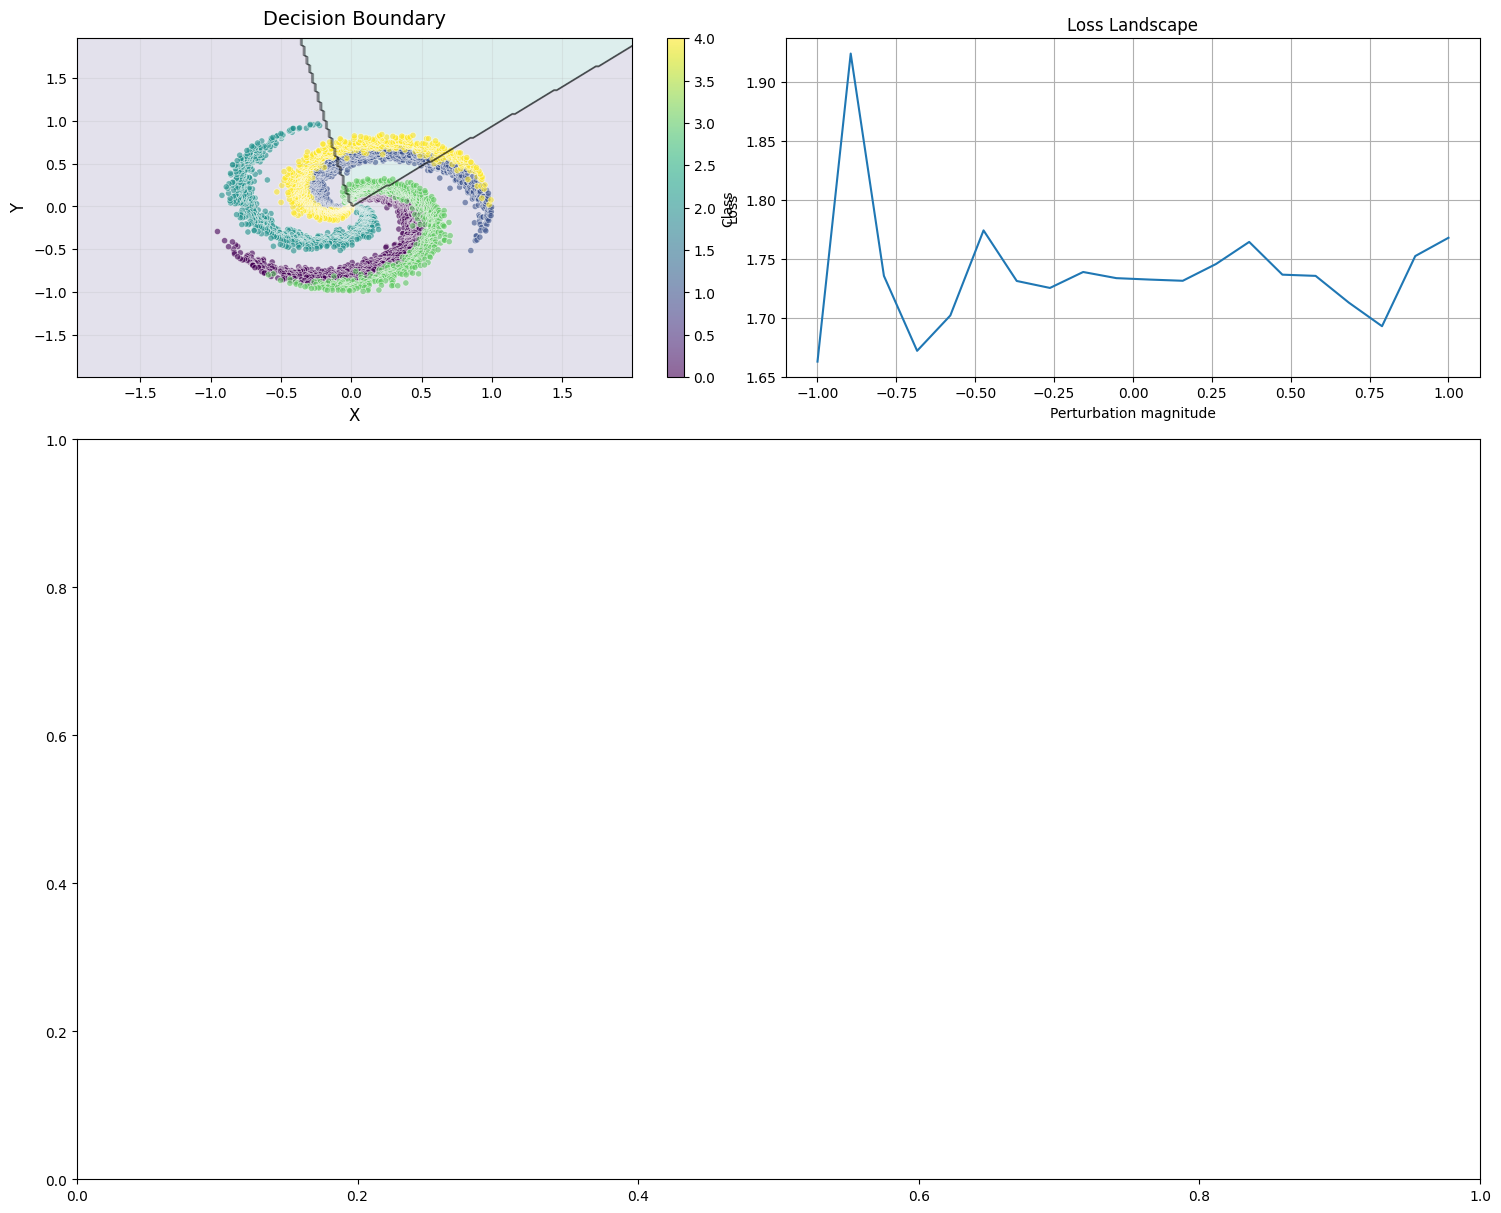

In [26]:
# put everything together and train the model on spiral dataset with cross-validation

x_train, y_train = generate_spiral_data(1000, 5)
x_test, y_test = generate_spiral_data(200, 5)
train_dataset = Dataset(x_train, y_train)
test_dataset = Dataset(x_test, y_test)

model = Sequential([
    Linear(2,32),
    ReLU(),
    Linear(32, 5),
])

loss_fn = CrossEntropySoftMax()
optimizer = SGD(learning_rate=0.1)
trainer = Trainer(model, loss_fn, optimizer)


trainer.train_with_cv(
    train_dataset, 
    cv=CrossValidator("k-fold", k=5),
    debug=False,
    epochs=1000,
    patience=100,
    log_interval=50,
    batch_size=64,
    show_plots_logs=True,
    lr_scheduler= WarmupLRScheduler(
        initial_lr=0.005, 
        warmup_epochs=50,
    ),
    weight_decay=0.01,
    momentum=0.9,
    )

# Create test loader and evaluate
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)
test_acc = trainer.compute_accuracy(test_loader)
print(f"\nFinal Test Accuracy: {test_acc:.2f}%")